In [1]:
import anndata as ad
import pandas as pd
import shapely
import shapely.plotting as splot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
adata = ad.read_h5ad("../data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad")
adata

AnnData object with n_obs × n_vars = 191578 × 550
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    u

In [4]:
adata.obs['cirro_x'] = adata.obsm['spatial_cirro'][:,0]
adata.obs['cirro_y'] = adata.obsm['spatial_cirro'][:,1]

# define and view CCF polygons

In [5]:
def plot_shape(poly, **kwargs):
    if type(poly) is shapely.GeometryCollection:
        for subpoly in poly.geoms:
            patch = splot.plot_polygon(subpoly, add_points=False, **kwargs)
    else:
        patch = splot.plot_polygon(poly, add_points=False, **kwargs)
    return patch

In [6]:
from collections import defaultdict
from shapely.ops import unary_union
from sklearn.cluster import OPTICS, DBSCAN, k_means

def poly_from_points(X):
    if X.shape[0] < 10:
        return None
    poly = shapely.concave_hull(shapely.multipoints(X), allow_holes=True, ratio=0.3)
    if type(poly) is shapely.Polygon:
        return poly
    else:
        return None

In [7]:
# data = adata.obs.query("section=='1199651024'")

# ccf_polygons = defaultdict(dict)  
# for (name, section), df in data.groupby(['CCF_acronym', 'section']):
#     X = df[['cirro_x','cirro_y']].values
#     if X.shape[0] > 100:
#         clusters = OPTICS(min_cluster_size=50, min_samples=10, n_jobs=2).fit_predict(X)
#         results = [poly_from_points(X[clusters==i, :]) for i in set(clusters) if not i==-1]
#         ccf_polygons[name][section] = unary_union(results)
        

In [31]:
def get_ccf_polygons(data, min_points=50, midline_gap=100):
    ccf_polygons = defaultdict(dict)  
    for (name, section), df in data.groupby(['CCF_acronym', 'section']):
        X = df[['cirro_x','cirro_y']].values
        if X.shape[0] > min_points:
            centroids, _, _ = k_means(X, 2, n_init=5)
            midpoint = np.mean(centroids, 0)[0]
            # midpoint = df['cirro_x'].mean()
            if np.min(np.abs(X[:,0] - midpoint)) > midline_gap:
                left = X[X[:,0] < midpoint]
                right = X[X[:,0] > midpoint]
                ccf_polygons[name][section] = unary_union([poly_from_points(left), poly_from_points(right)])
            else:
                poly = poly_from_points(X)
                if poly is not None:
                    ccf_polygons[name][section] = poly
    return ccf_polygons

In [32]:
ccf_polygons = get_ccf_polygons(adata.obs)

## view all slices with polygons and labeled points

In [86]:
sec_group_counts.head(10)

PST     1
bic     1
DT      2
MRN     4
opt     6
GPi    10
PVi    13
SNr    28
NB     29
st     29
Name: CCF_acronym, dtype: int64

In [90]:
sec_group_counts = adata.obs['CCF_acronym'].value_counts(ascending=True)
totals = sec_group_counts.values.cumsum()[:-1]
totals

array([     1,      2,      4,      8,     14,     24,     37,     65,
           94,    123,    166,    228,    295,    365,    452,    553,
          655,    760,    893,   1028,   1165,   1307,   1499,   1711,
         1949,   2192,   2466,   2749,   3037,   3329,   3659,   4024,
         4414,   4827,   5292,   5787,   6302,   6863,   7431,   8016,
         8632,   9280,   9938,  10638,  11359,  12088,  12817,  13557,
        14310,  15072,  15854,  16650,  17517,  18424,  19419,  20431,
        21508,  22590,  23677,  24769,  26002,  27288,  28583,  29924,
        31307,  32717,  34276,  35892,  37522,  39219,  40993,  42800,
        44617,  46695,  48871,  51049,  53337,  55891,  58510,  61538,
        64785,  68061,  71369,  74803,  78463,  82157,  86491,  90993,
        95903, 101331, 106785, 112459, 118561, 125418, 133760, 143085,
       154033, 165564, 178037])

In [91]:
sec_group_counts.values[totals <= sec_group_counts.values[1:]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 99

In [94]:
import colorcet as cc

def plot_ccf_overlay(obs, ccf_polygons, sections=None, point_hue='CCF_acronym', legend=True, min_group_count=10, highlight=[]):
    obs = obs.copy()
    if sections is None:
        sections = obs['section'].unique()
    ccf_names = ccf_polygons.keys()
    shape_palette = dict(zip(ccf_names, sns.color_palette(cc.glasbey, n_colors=len(ccf_names))))
    
    obs[point_hue] = obs[point_hue].astype(str)
    point_group_names = obs[point_hue].value_counts().loc[lambda x: x>min_group_count].index
    obs = obs.loc[lambda df: df[point_hue].isin(point_group_names)]
    
    if point_hue == 'CCF_acronym':
        point_palette = shape_palette.copy()
        extra_names = point_group_names.difference(ccf_names)
        extra_palette = dict(zip(extra_names, sns.color_palette(cc.glasbey, n_colors=len(point_group_names))[-len(extra_names):]))
        point_palette.update(extra_palette)
    else:
        point_palette = dict(zip(point_group_names, sns.color_palette(cc.glasbey, n_colors=len(point_group_names))))
    point_palette.update(other='grey')
    
    for section in sections:
        secdata = obs.loc[lambda df: (df['section']==section)].copy() #& df['CCF_acronym'].isin(ccf_names)]
        if len(secdata) < min_group_count:
            continue
            
        plt.figure(figsize=(10,4))
        plt.title(section)
        patches = []
        for i, name in enumerate(ccf_polygons.keys()):
            if section in ccf_polygons[name]:
                patches.append(plot_shape(ccf_polygons[name][section], color=shape_palette[name], 
                                          alpha=0.4 if name in highlight else 0.1, 
                                          label=name if legend=='CCF' else None))
        sec_group_counts = secdata[point_hue].value_counts(ascending=True)
        if len(sec_group_counts) > 10:
            # lump small groups if legend list is too long
            point_groups_section = sec_group_counts.loc[lambda x: x>min_group_count].index
            secdata.loc[lambda df: ~df[point_hue].isin(point_groups_section), point_hue] = 'other'
        sns.scatterplot(secdata, x='cirro_x', y='cirro_y', hue=point_hue, s=2, palette=point_palette, legend=legend is True)
        if legend=='CCF':
            plt.legend(title='CCF regions', handles=patches, ncols=2, loc='upper left', bbox_to_anchor=(1,1))
        elif legend:
            plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(1,1))
            

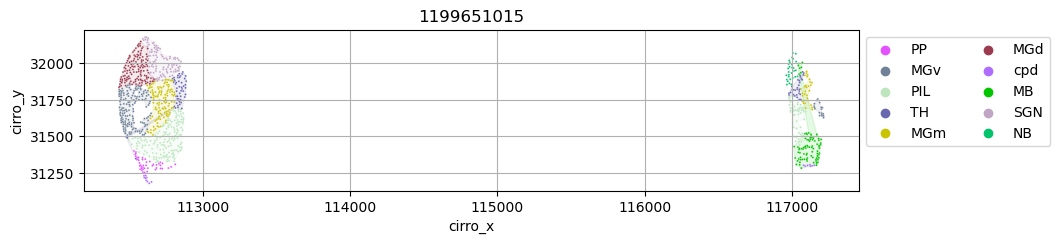

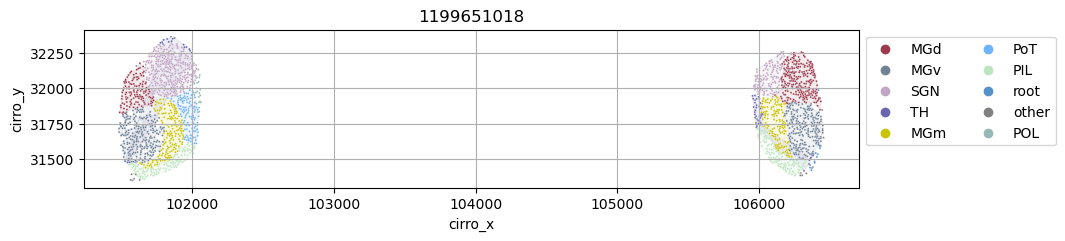

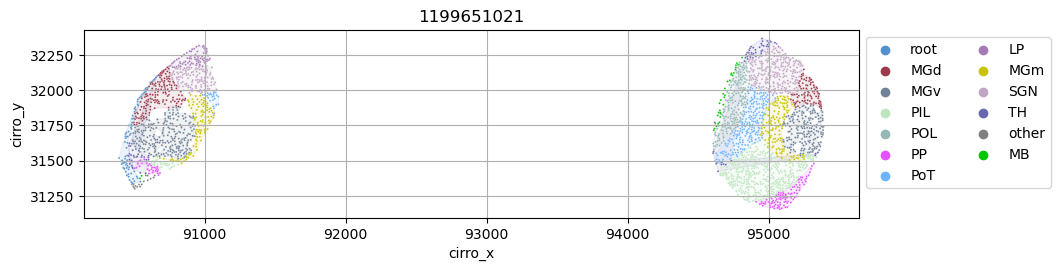

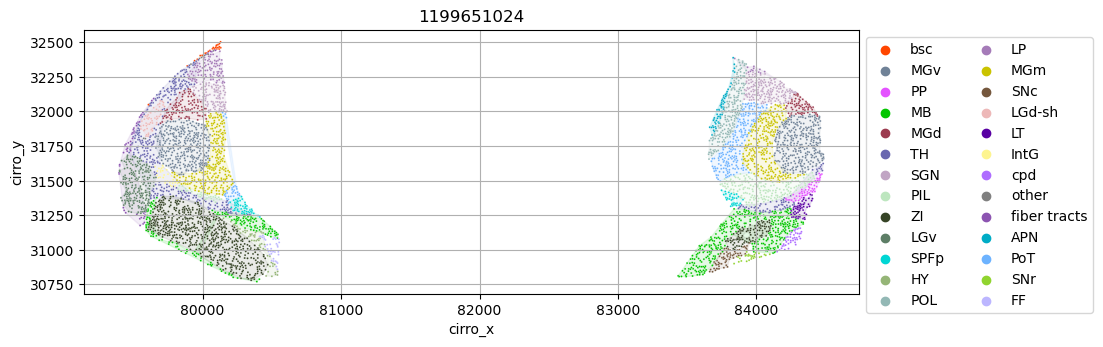

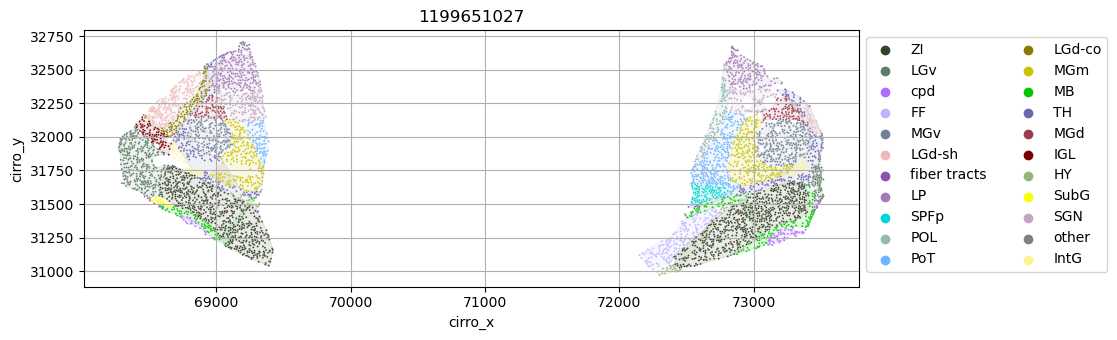

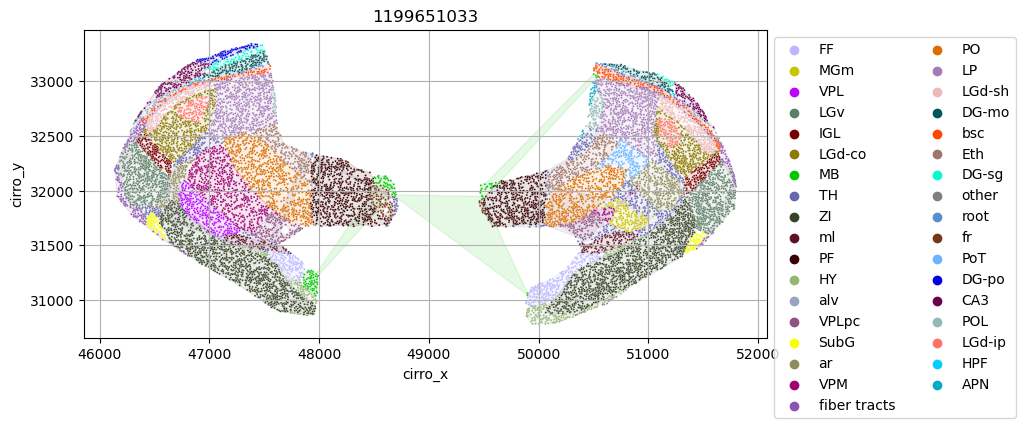

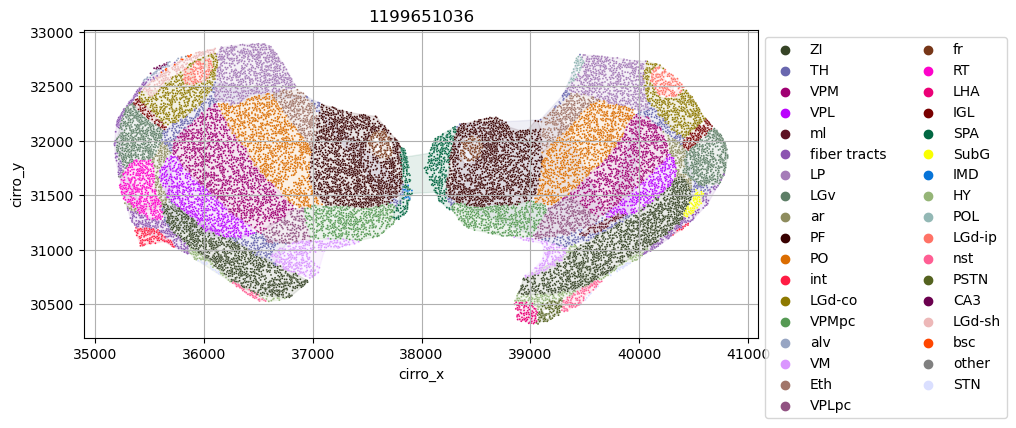

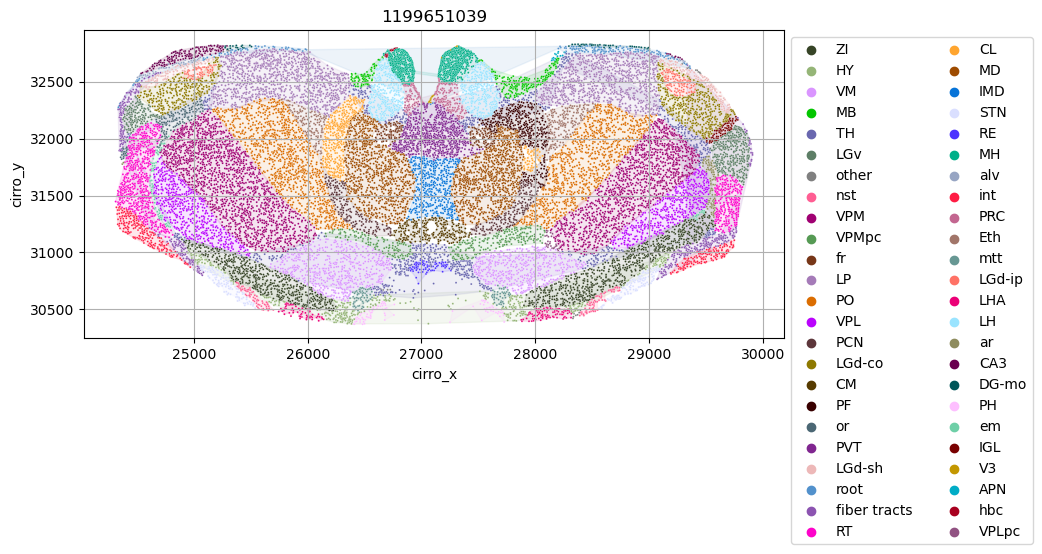

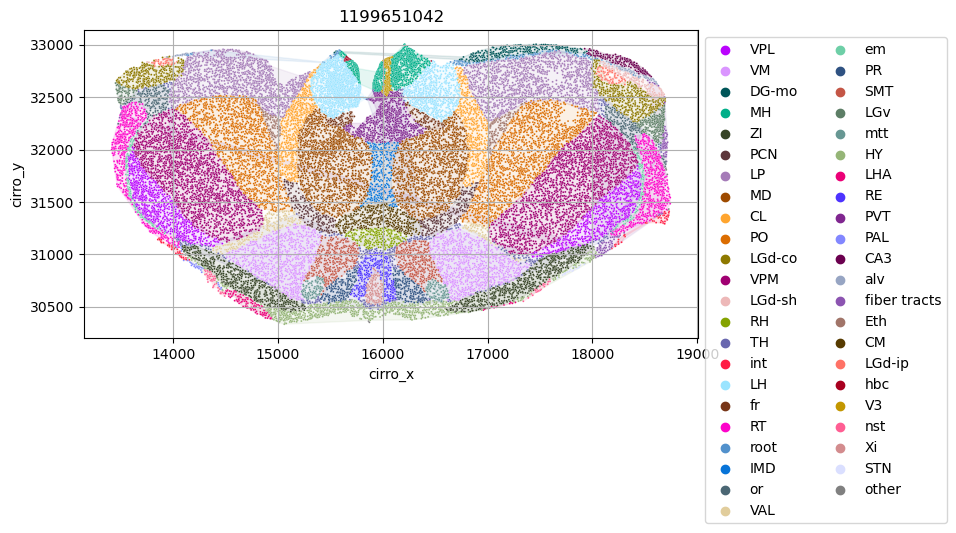

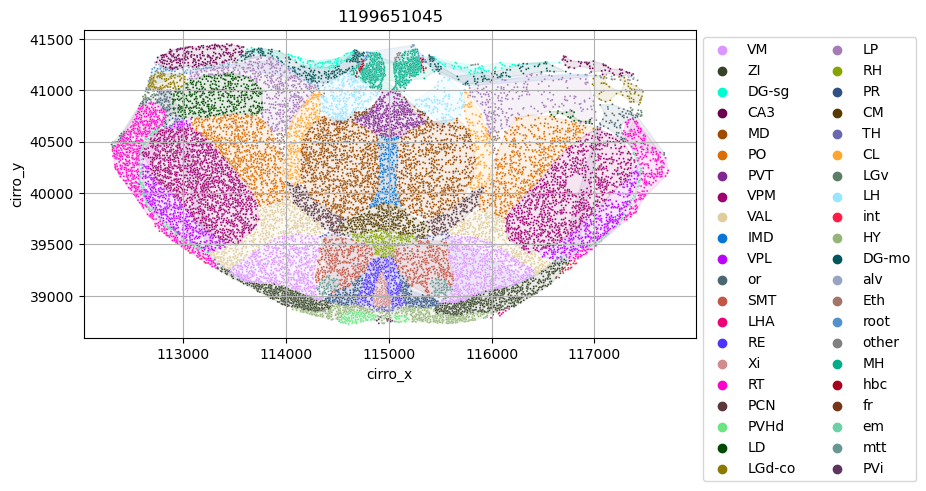

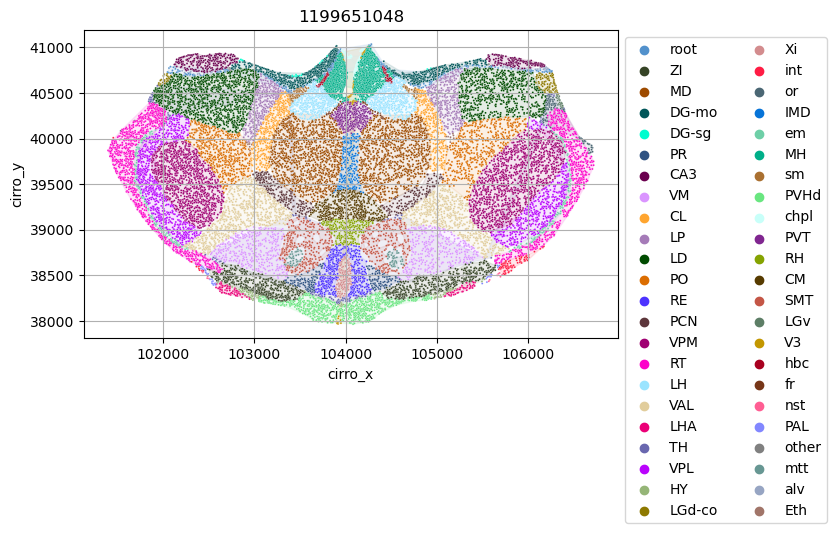

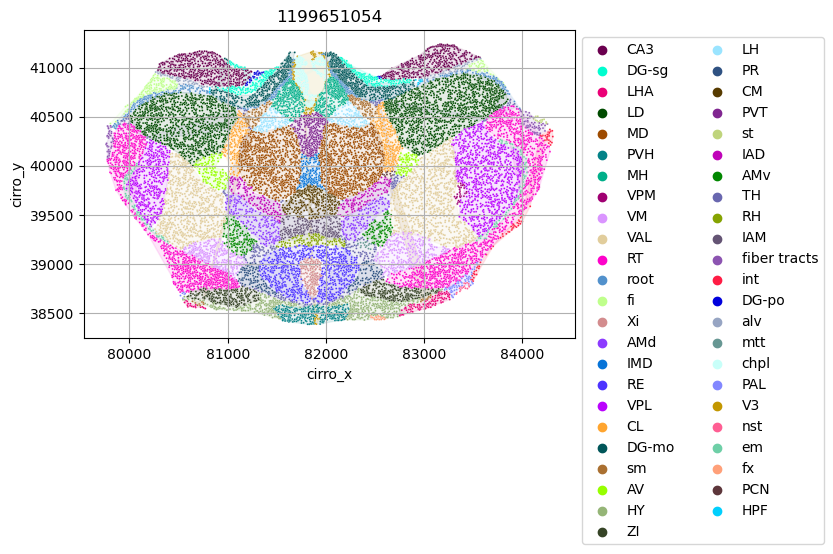

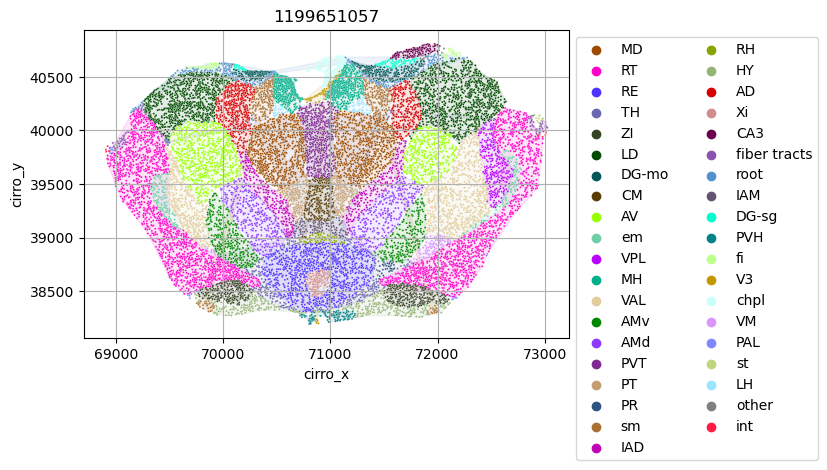

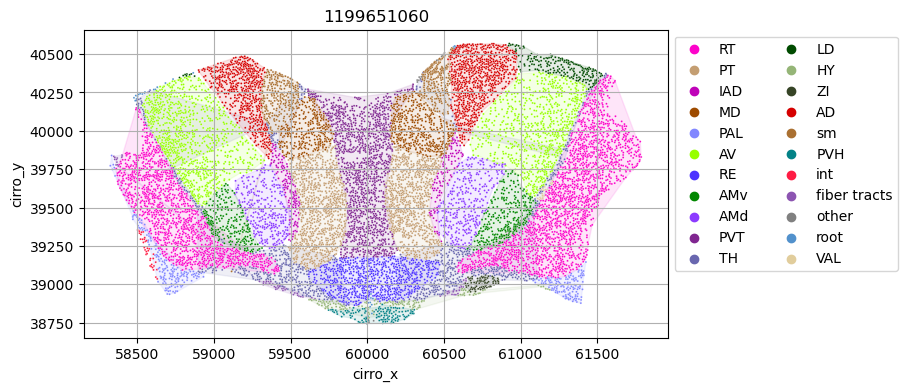

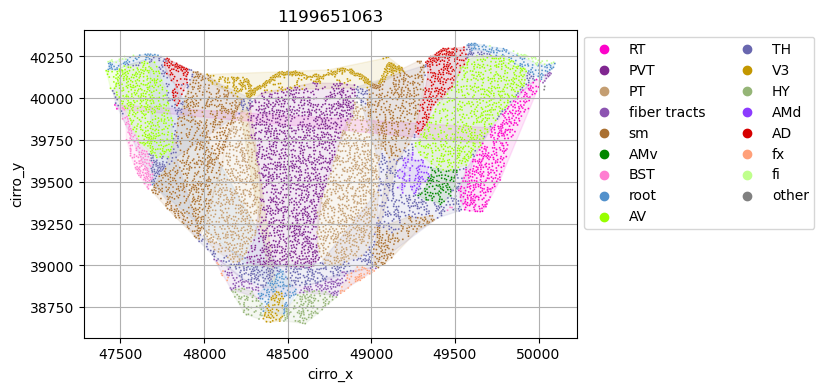

In [95]:
plot_ccf_overlay(adata.obs, ccf_polygons, legend=True)

## view with subclass labels

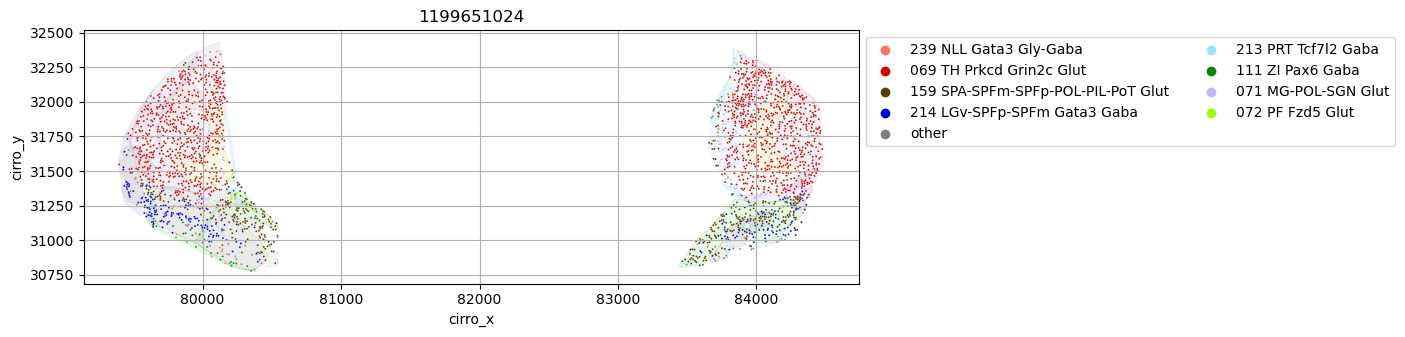

In [96]:
sections = ['1199651024']
obs = adata.obs.loc[lambda df: df['division_id_label']=='3 PAL-sAMY-TH-HY-MB-HB neuronal']
plot_ccf_overlay(obs, ccf_polygons, sections, point_hue='subclass_id_label', legend=True)

# Investigate prong 1 cluster-nucleus groups

In [54]:
nuclei_df = pd.read_csv("../resources/Prong 1 Vitessce links by nucleus.csv", index_col=0)

In [55]:
def plot_nucleus_cluster_comparison_slices(name, adata, nuclei_df, ccf_polygons, subregions=None, legend=True):
    clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
    obs = adata.obs.loc[lambda df: df['cluster_label'].str[:4].isin(clusters)]
    sections = obs['section'].value_counts().loc[lambda x: x>10].index.sort_values()
    nuclei = subregions or [name]
    plot_ccf_overlay(obs, ccf_polygons, sections, point_hue='cluster_label', legend=legend, highlight=nuclei)

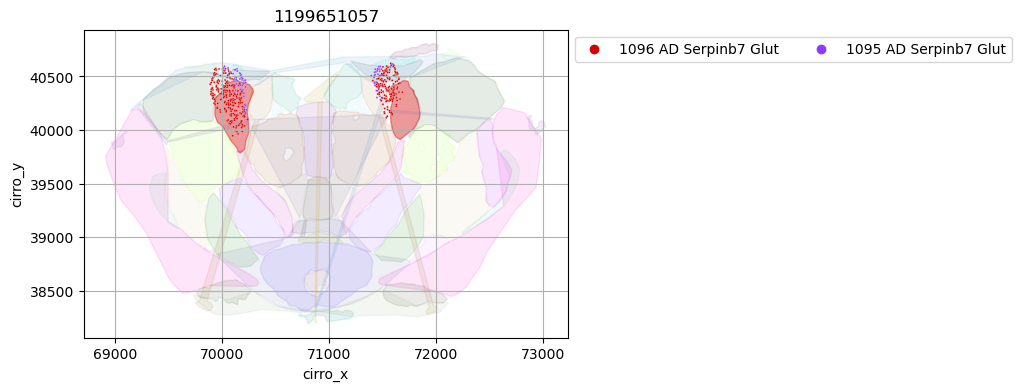

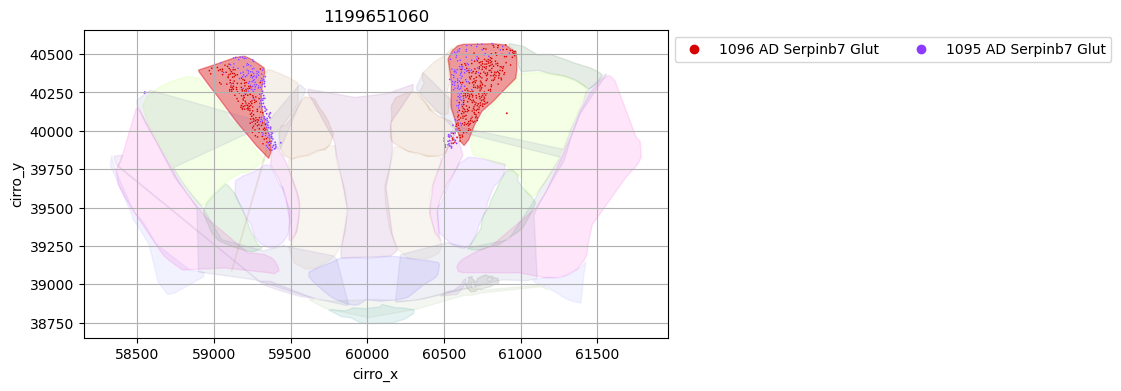

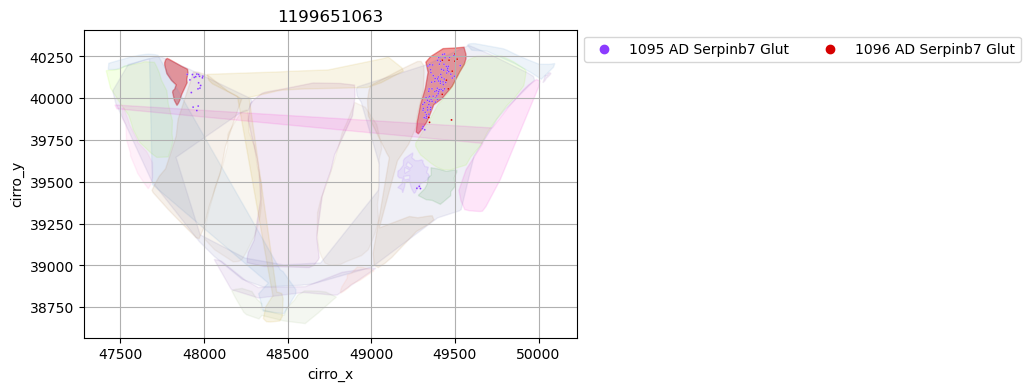

In [56]:
plot_nucleus_cluster_comparison_slices('AD', adata, nuclei_df, ccf_polygons)

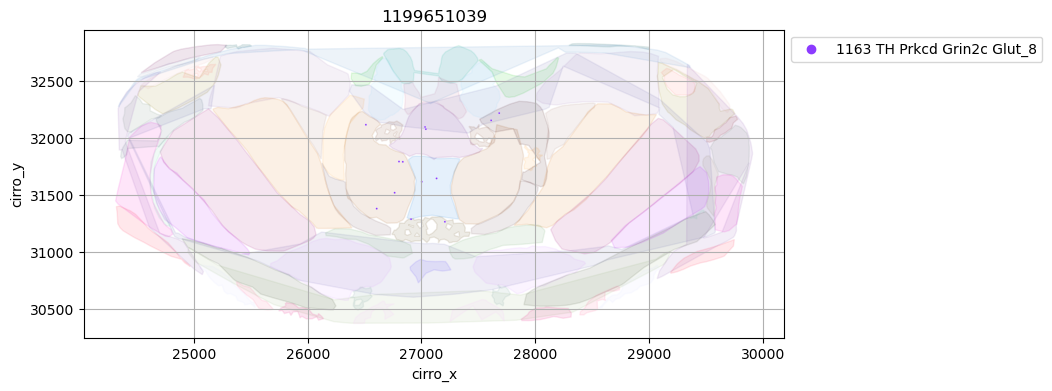

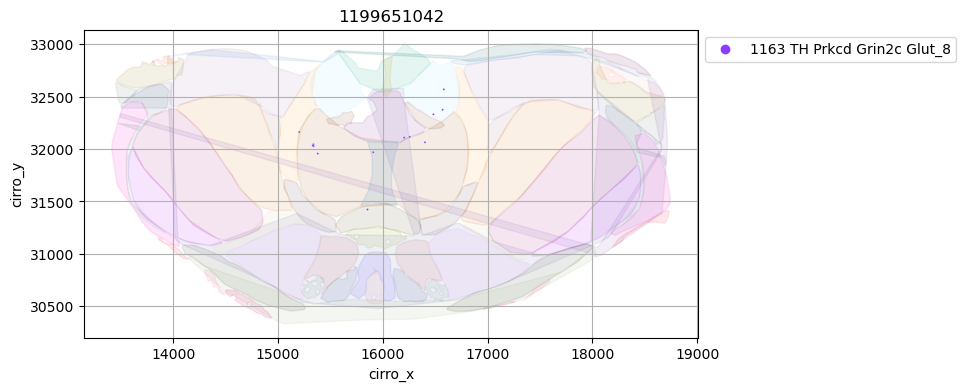

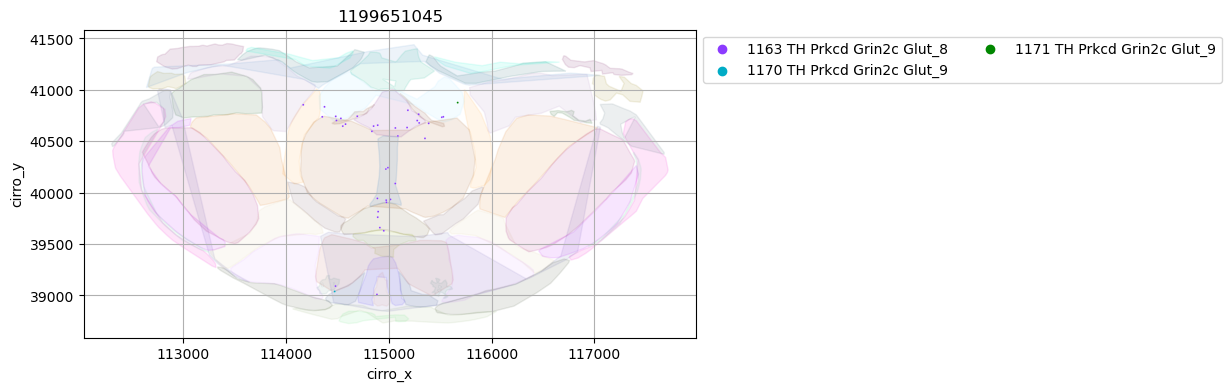

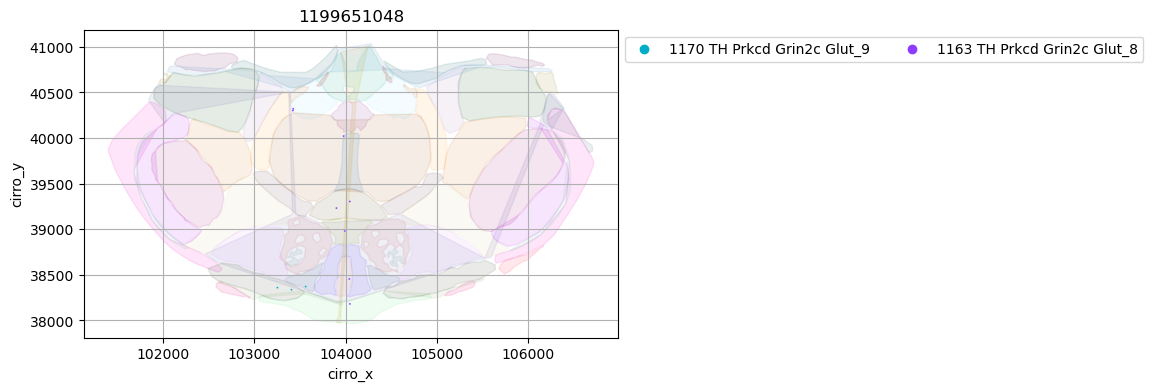

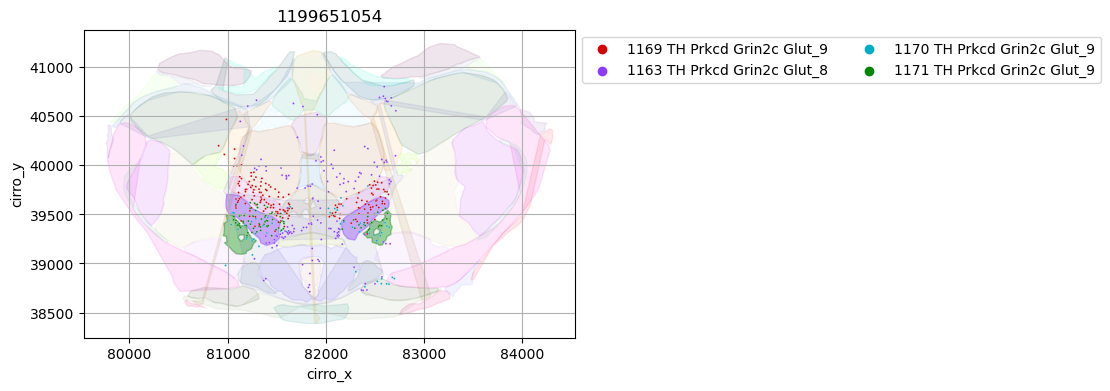

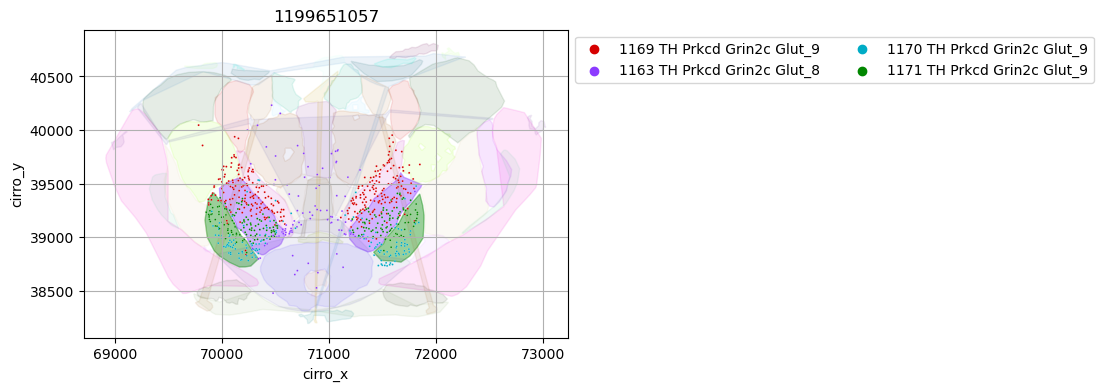

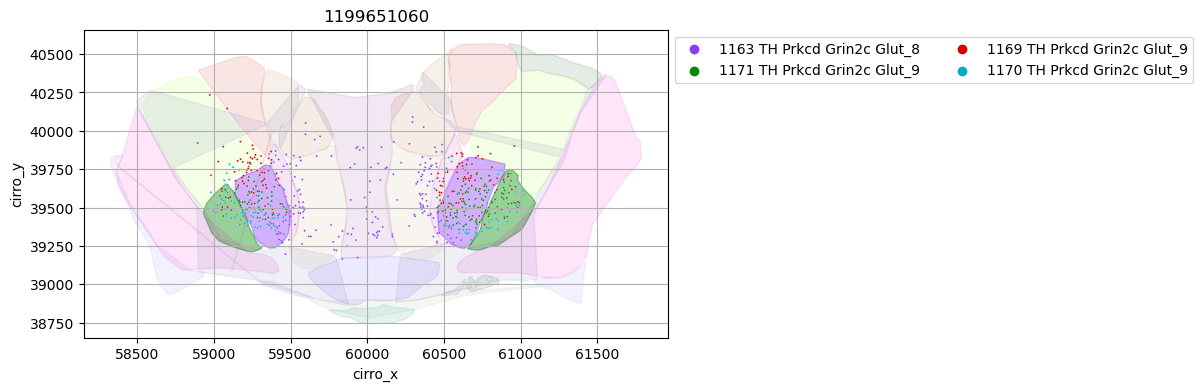

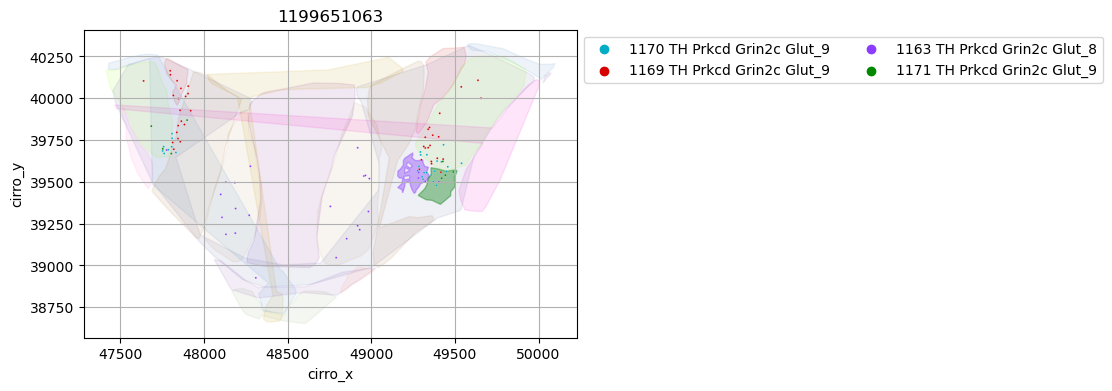

In [64]:
plot_nucleus_cluster_comparison_slices('AM', adata, nuclei_df, ccf_polygons, subregions=['AMd','AMv'])

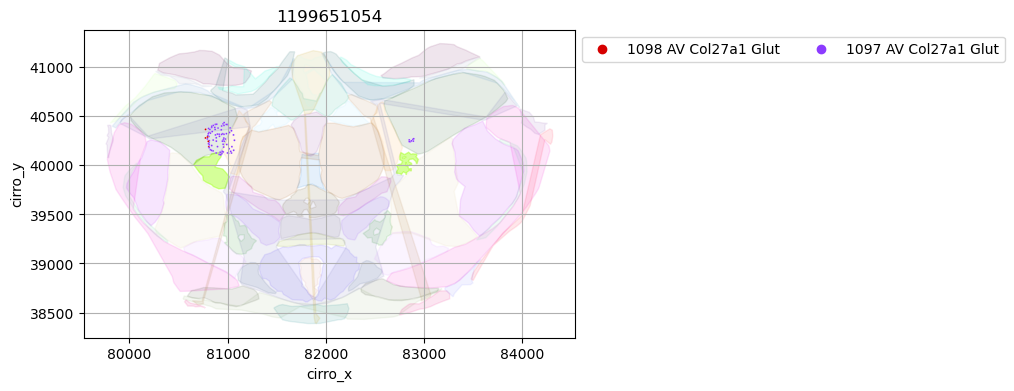

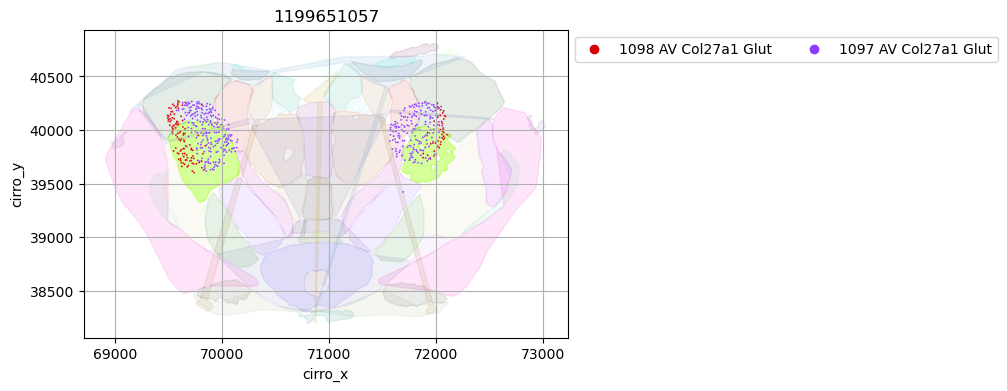

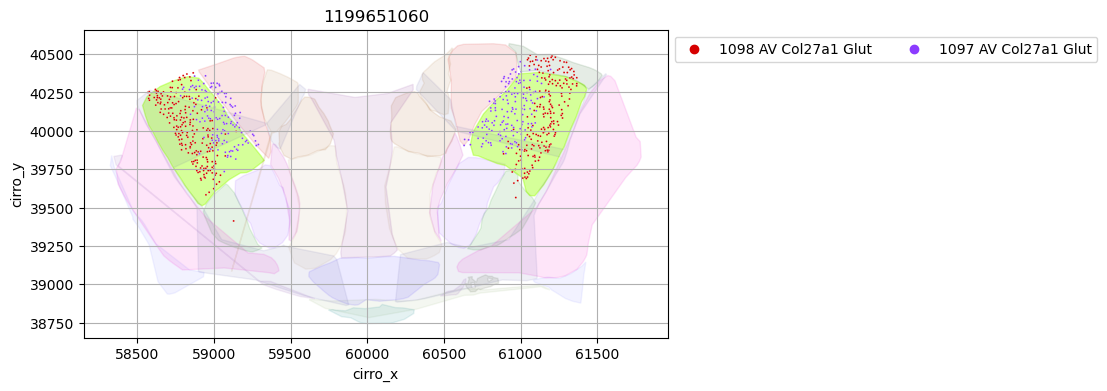

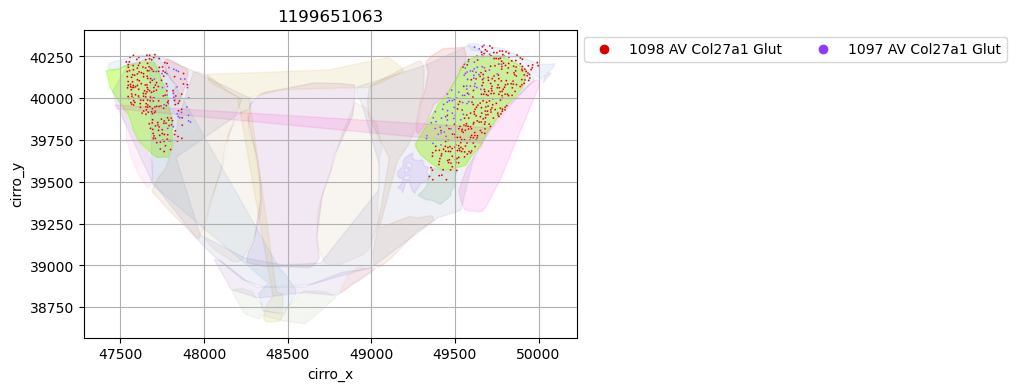

In [65]:
plot_nucleus_cluster_comparison_slices('AV', adata, nuclei_df, ccf_polygons)

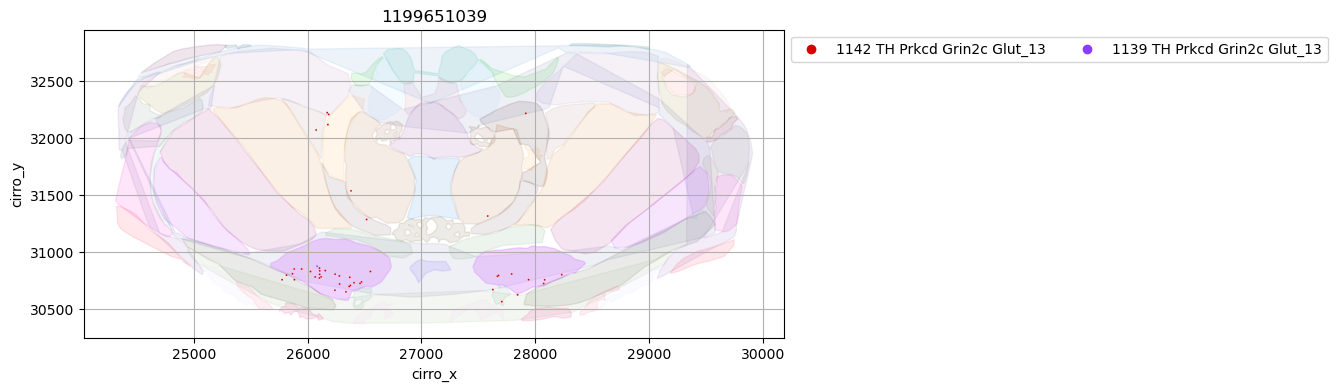

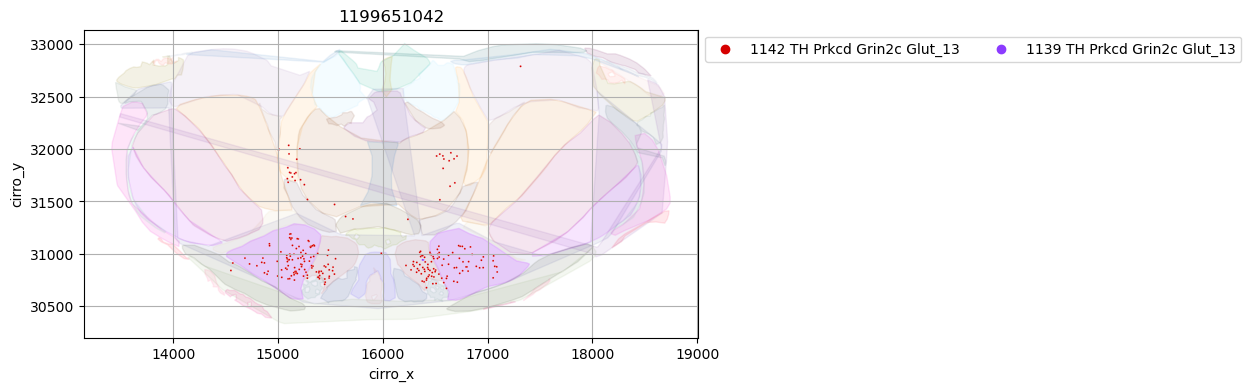

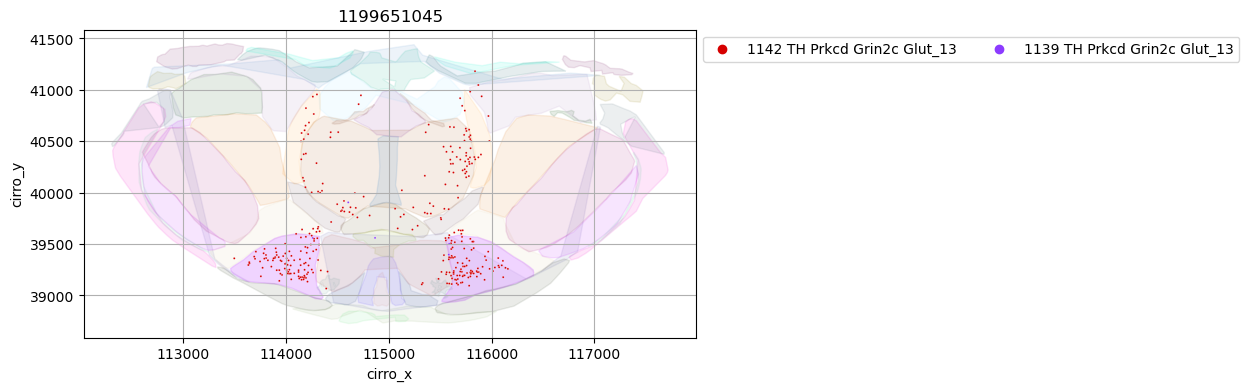

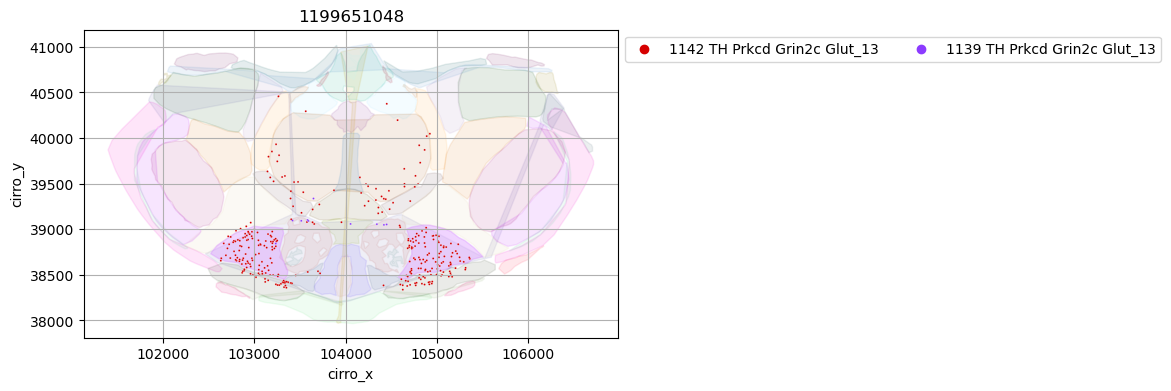

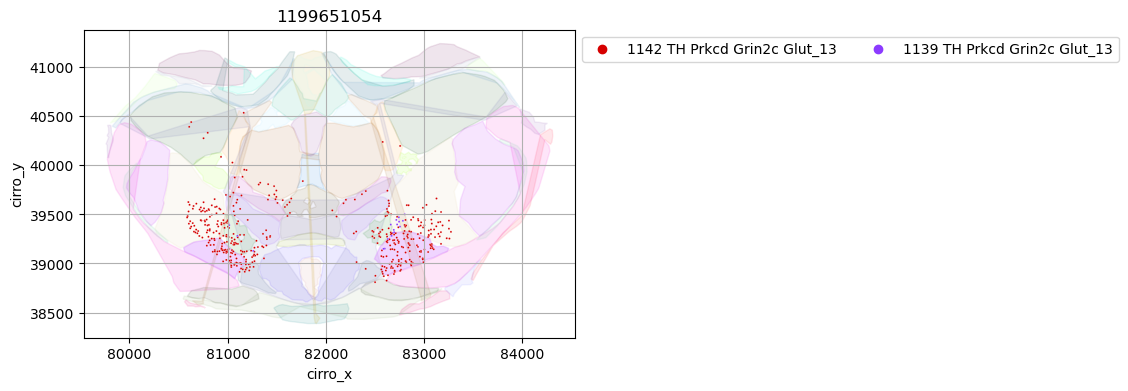

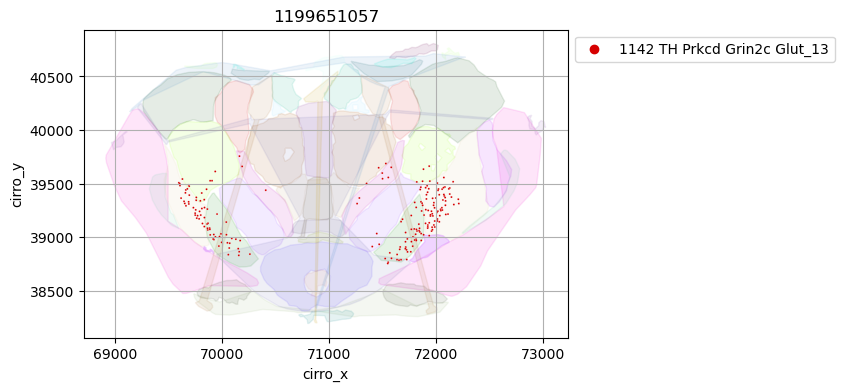

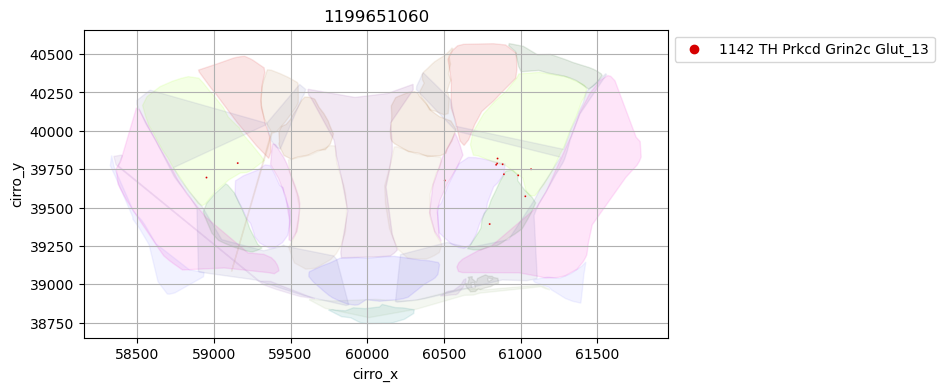

In [66]:
plot_nucleus_cluster_comparison_slices('VM', adata, nuclei_df, ccf_polygons)

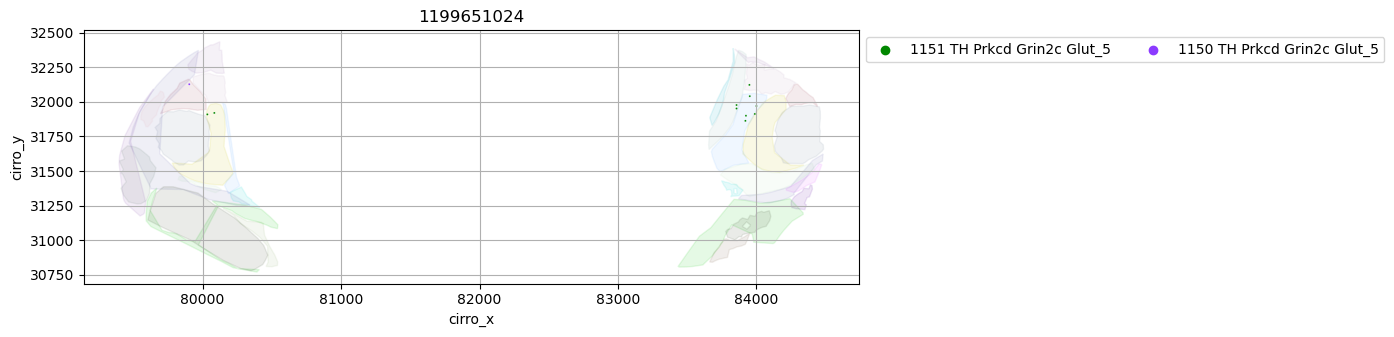

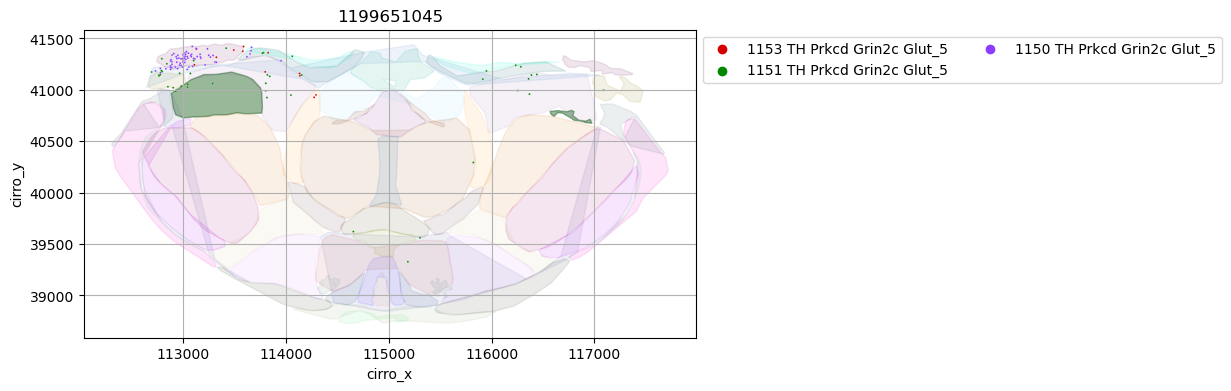

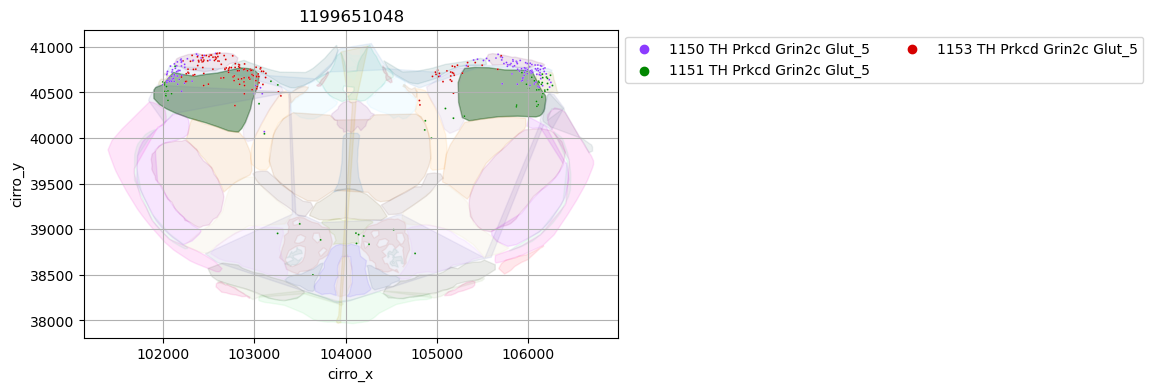

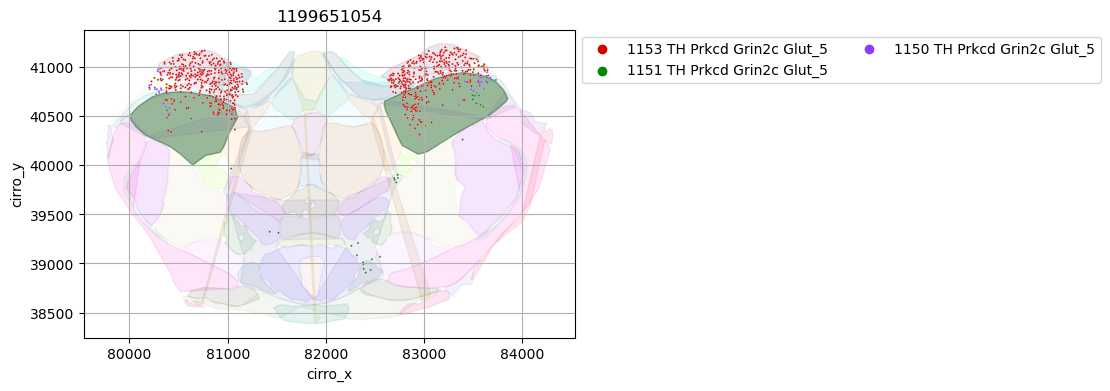

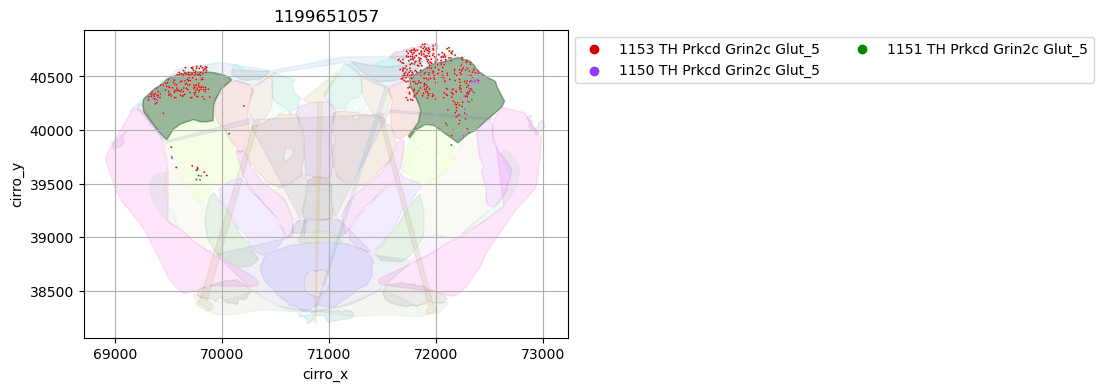

In [67]:
plot_nucleus_cluster_comparison_slices('LD', adata, nuclei_df, ccf_polygons)

## flat view plots

In [28]:
# def plot_nucleus_cluster_comparison(name, adata, nuclei_df, ccf_polygons, subregions=None):
#     plt.figure(figsize=(40,10))
#     if subregions is not None:
#         for x in subregions:
#             for poly in ccf_polygons[x].values():
#                 splot.plot_polygon(poly, color='grey', add_points=False)
#     else:
#         for poly in ccf_polygons[name].values():
#             splot.plot_polygon(poly, color='grey', add_points=False)
#     clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
#     df = adata.obs.loc[lambda df: df['cluster_label'].str[:4].isin(clusters)]
#     df['cluster_label'].cat.remove_unused_categories(inplace=True)
#     sns.scatterplot(df, x='cirro_x', y='cirro_y', hue='cluster_label', s=2)